## Integrantes:
- **Antonella Sofia Rivano**
- **Candelaria Sturm**
- **Gabriel Nuñez Moreno** 

### Importamos todas las librerias que usaremos

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score    # Herramientas de validación
from formulaic import Formula

### Cargamos los datos 

El dataset esta subido en el campus, sin embargo, fueron sacados de la pagina de la [secretaria de transporte](https://datos.transporte.gob.ar/dataset/sube-cantidad-de-transacciones-usos-por-fecha)

In [2]:
# Cargamos los datos
sube = pd.read_csv("sube-2023.csv")

### 1. (a) Visualizar el tipo de datos de cada columna. Transformar la columna `DIA_TRANSPORTE` para que sea reconocida como una fecha

In [11]:
# Para visualizar el tipo de dato de cada columna usamos .info()
sube.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472291 entries, 0 to 472290
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   472291 non-null  object
 1   NOMBRE_EMPRESA   472291 non-null  object
 2   LINEA            472291 non-null  object
 3   AMBA             472291 non-null  object
 4   TIPO_TRANSPORTE  472291 non-null  object
 5   JURISDICCION     469742 non-null  object
 6   PROVINCIA        469720 non-null  object
 7   MUNICIPIO        469720 non-null  object
 8   CANTIDAD         472291 non-null  int64 
 9   DATO_PRELIMINAR  472291 non-null  object
dtypes: int64(1), object(9)
memory usage: 36.0+ MB


Observemos que pandas solo tomo la columna `CANTIDAD` como tipo entero, los restantes solo como `object`
Tranformamos la columna `DIA_TRANSPORTE` a tipo datetime 

In [12]:
sube["DIA_TRANSPORTE"] = pd.to_datetime(sube["DIA_TRANSPORTE"])

#### **1. (b)** Agregar tres columnas al DataFrame:
#### i. `FECHA_DIA` : debe indicar el nombre del día de la semana correspondiente a`DIA_TRANSPORTE`

#### ii. `FECHA_ORDINAL` : debe indicar el ordinal correspondiente a `DIA_TRANSPORTE` (porejemplo, a 2023-01-01 le corresponde 1, a 2023-01-02 le corresponde 2 y así sucesivamente). Debe ser un entero (int).

#### iii. `FECHA_MES` : debe indicar el mes correspondiente a `DIA_TRANSPORTE`

Documentacion usada para 
1.  [`dt.day_name()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.day_name.html)
2. [`dt.day`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.day.html)
3. [`dt.month`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.month.html)

In [13]:
sube["FECHA_DIA"] = sube["DIA_TRANSPORTE"].dt.day_name()
sube.head(2)

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,FECHA_DIA
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO,Sunday
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO,Sunday


In [14]:
sube["FECHA_ORDINAL"] = sube["DIA_TRANSPORTE"].dt.day
sube["FECHA_MES"] = sube["DIA_TRANSPORTE"].dt.month

### 2. Crear el DataFrame `datos_amba`, el cual sólo debe tener datos de AMBA y debe excluir datos preliminares

In [18]:
datos_amba = sube[sube["AMBA"] == "SI"]
datos_amba = datos_amba[["DIA_TRANSPORTE", "FECHA_DIA", "FECHA_MES", "FECHA_ORDINAL", "JURISDICCION", "LINEA", "CANTIDAD","TIPO_TRANSPORTE"]]
datos_amba.columns = ["fecha","fecha_dia","fecha_mes","fecha_ordinal","jurisdiccion","linea","pasajeros","tipo_transporte"]
datos_amba.head(5)

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Sunday,1,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Sunday,1,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Sunday,1,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Sunday,1,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Sunday,1,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


### 3. Utilizando datos_amba, identificar

#### `(a)` la proporción de la cantidad total anual de pasajeros que le corresponde a cada medio de transporte

In [8]:
# La proporcion de la cantidad total anual de pasajeros que le corresponde a cada tipo de transporte
datos_amba.groupby("tipo_transporte")["pasajeros"].sum()/datos_amba["pasajeros"].sum() * 100

tipo_transporte
COLECTIVO    83.767693
SUBTE         6.808356
TREN          9.423951
Name: pasajeros, dtype: float64

#### `(b)` la tupla (mes, línea de subte) donde viajó la mayor cantidad de pasajeros

In [9]:
datos_amba_subte = datos_amba[datos_amba["tipo_transporte"]=="SUBTE"]
ordenado = datos_amba_subte.sort_values(by="pasajeros",ascending=False)[["fecha_mes","linea"]].head(1)
tuple(ordenado.values[0])

(12, 'LINEA_B')

#### `(c)` el día hábil con menor desvío estándar en cantidad de pasajeros

In [10]:
datos_amba.groupby("fecha_dia")["pasajeros"].std().sort_values(ascending=True).head(7)

fecha_dia
Sunday       10370.822082
Saturday     21540.806371
Monday       33573.895343
Friday       35056.183054
Tuesday      35830.872527
Thursday     35964.585445
Wednesday    35977.215721
Name: pasajeros, dtype: float64

##### `RTA:` El dia habil con menor desvío estandar es Lunes

## 4. Análisis exploratorio.

La idea de este ítem es que realicen un análisis exploratorio de los datos, aplicando las herramientas de visualización (`seaborn.objects`, `seaborn` y/o `matplotlib`) y de resumen de datos (media, mediana, desvío estándar, operaciones sobre el DataFrame, etc.)

El objetivo es entender, comparar y/o estudiar aspectos o patrones en la cantidad de pasajeros
del transporte público. Algunas preguntas disparadoras pueden ser:
+ ¿Cómo varía el uso del transporte público a lo largo del año? ¿Se observa el mismo efecto
en AMBA y en el interior del país? ¿Y en todos los medios de transporte por igual?
+ ¿Cómo difiere el uso del transporte público durante los días hábiles en comparación a los
fines de semana?
+ ¿Hay algún día hábil que resulte un outlier? ¿Pueden explicarlo?


In [16]:
# La unica columna en la cual podemos hacer un resumen de datos es en cantidad 
sube.describe()

,CANTIDAD
count,472291.000000
mean,9336.927454
std,20609.074234
min,-417.000000
25%,683.000000
50%,2627.000000
75%,9062.000000
max,542616.000000


Notemos que hay algo fuera de lo comun que es el minimo: $-417$ 
- ¿Tiene sentido que hayan viajado $- 417$ pasajeros? 
- ¿Como interpretamos esto?

In [17]:
sube[sube["CANTIDAD"]== -417]

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
388788,2023-10-30,SOFSE- SARMIENTO,FFCC SAR MERLO - LOBOS,SI,TREN,NACIONAL,JN,SD,-417,NO


Esto nos hace pensar: ¿Hay mas filas que tengan una cantidad negativa de pasajeros?

In [37]:
sube[sube["CANTIDAD"]<0]

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,FECHA_DIA,FECHA_ORDINAL,FECHA_MES
284929,2023-08-13,SOFSE- SARMIENTO,FFCC SAR MERLO - LOBOS,SI,TREN,NACIONAL,JN,SD,-25,NO,Sunday,13,8
284930,2023-08-13,SOFSE- SARMIENTO,FFCC SAR MORENO - MERCEDES,SI,TREN,NACIONAL,JN,SD,-1,NO,Sunday,13,8
284933,2023-08-13,SOFSE - Belgrano Sur,FFCC_BELG_SUR,SI,TREN,NACIONAL,JN,SD,-11,NO,Sunday,13,8
378164,2023-10-22,SOFSE - Belgrano Sur,FFCC_BELG_SUR,SI,TREN,NACIONAL,JN,SD,-1,NO,Sunday,22,10
387623,2023-10-29,SOFSE- SARMIENTO,FFCC SAR MERLO - LOBOS,SI,TREN,NACIONAL,JN,SD,-92,NO,Sunday,29,10
388788,2023-10-30,SOFSE- SARMIENTO,FFCC SAR MERLO - LOBOS,SI,TREN,NACIONAL,JN,SD,-417,NO,Monday,30,10


Consideramos que esto se debe a un error humano a la hora de cargar los datos a la base de datos del ministerio de Transporte. Por lo que, los eliminamos. 

In [15]:
# Agarramos solo los datos que sean mayores o iguales a 0
sube = sube[sube["CANTIDAD"]>0]

### ¿Cómo varía el uso del transporte público a lo largo del año?

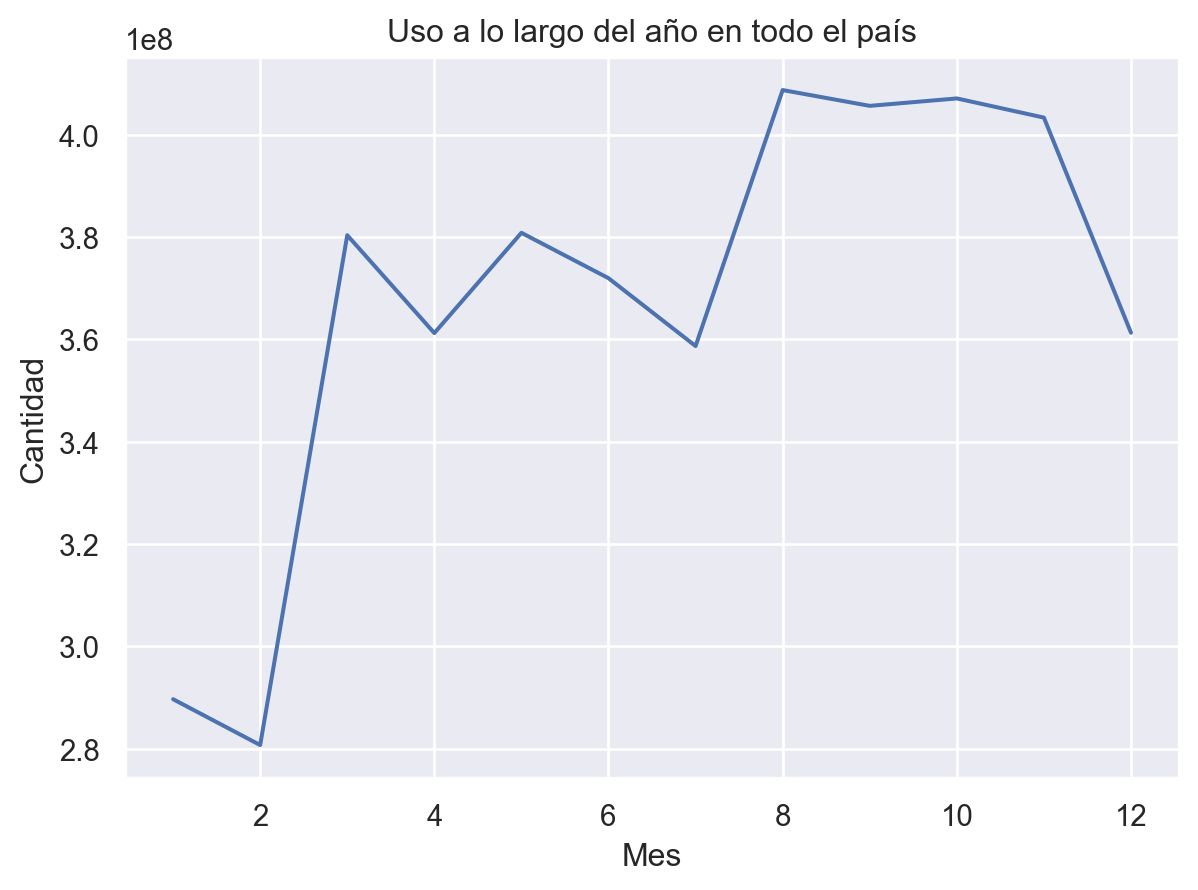

In [50]:
(
    so.Plot(data=sube, 
            x="FECHA_MES", 
            y="CANTIDAD")
    .add(so.Line(),so.Agg("sum"))
    .label(x="Mes",y="Cantidad",title="Uso a lo largo del año en todo el país")
)

In [17]:
# Hacemos algo similar pero para fuera del amba
datos_interior = sube[sube["AMBA"] == "NO"]
datos_interior = datos_interior[["DIA_TRANSPORTE", "FECHA_DIA", "FECHA_MES", "FECHA_ORDINAL", "JURISDICCION", "LINEA", "CANTIDAD","TIPO_TRANSPORTE"]]
datos_interior.columns = ["fecha","fecha_dia","fecha_mes","fecha_ordinal","jurisdiccion","linea","pasajeros","tipo_transporte"]

En la documentacion de la secretaria de transporte dice que las provincias que tienen `nan` son los que en `tipo_transporte` son `sube`. Por lo que cambiamos su nombre a `BUENOS AIRES`

In [87]:
print(sube["PROVINCIA"].unique())
sube["PROVINCIA"].fillna("BUENOS AIRES",inplace=True)
print(sube["PROVINCIA"].unique())

array(['BUENOS AIRES', 'JN', 'CHUBUT', 'SANTA FE', 'ENTRE RÍOS',
       'LA PAMPA', 'MENDOZA', 'RÍO NEGRO', 'TIERRA DEL FUEGO', 'CHACO',
       'JUJUY', 'NEUQUÉN', 'FORMOSA', 'CORRIENTES', 'CATAMARCA',
       'SAN JUAN', 'SAN LUIS', 'CORDOBA', 'SANTA CRUZ',
       'SANTIAGO DEL ESTERO'], dtype=object)

#### ¿Se observa el mismo efecto en AMBA y en el interior del país?

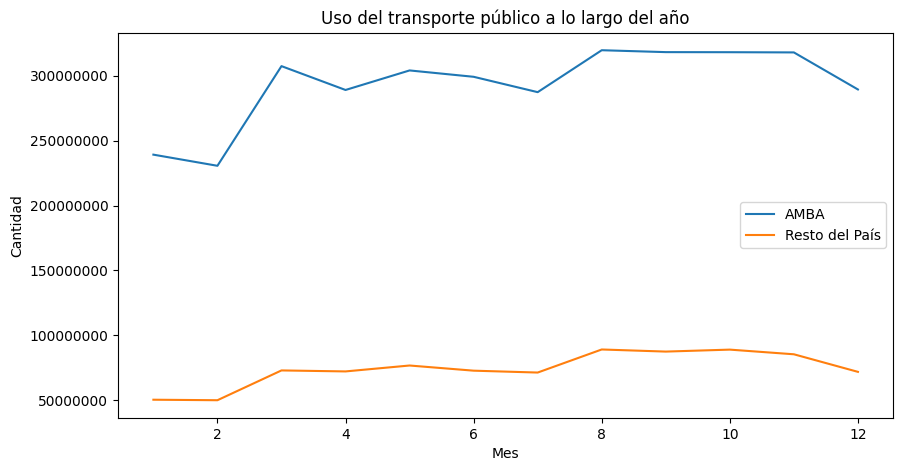

In [92]:
plt.figure(figsize=(10,5))
sns.lineplot(data=sube[sube["AMBA"]=="SI"].groupby("FECHA_MES")["CANTIDAD"].sum().reset_index(), x="FECHA_MES", y="CANTIDAD", label="AMBA")
sns.lineplot(data=sube[sube["AMBA"]=="NO"].groupby("FECHA_MES")["CANTIDAD"].sum().reset_index(), x="FECHA_MES", y="CANTIDAD", label="Resto del País")
plt.title("Uso del transporte público a lo largo del año")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show()

##### El comportamiento de ambas curvas es muy similar, aunque más pronunciado en el AMBA que en el resto del país. En enero y febrero, se observa una disminución considerable en el número de pasajeros, probablemente debido a que muchos habitantes están de vacaciones y hay un receso en las actividades escolares y universitarias. Además, se nota una leve disminución en los meses de junio y julio, atribuida al receso de invierno. En marzo, hay un notable incremento en la cantidad de pasajeros, coincidiendo con el inicio de clases.

##### La observación más notoria es la distancia entre las rectas. Algunas posibles causas de la diferencia entre las cantidades de pasajeros podrían deberse a múltiples factores entre ellos la diferencia en densidad de población (el AMBA es la zona más densa de Argentina), la diferencia entre infraestructura (es la única parte de Argentina con subte) y además las actividades productivas propias de cada provincia podrían no necesitar una movilización de los trabajadores hacia los centros. Por ejemplo, en *La Pampa* priman las actividades agrícolas



#### **¿Y en todos los medios de transporte por igual?**

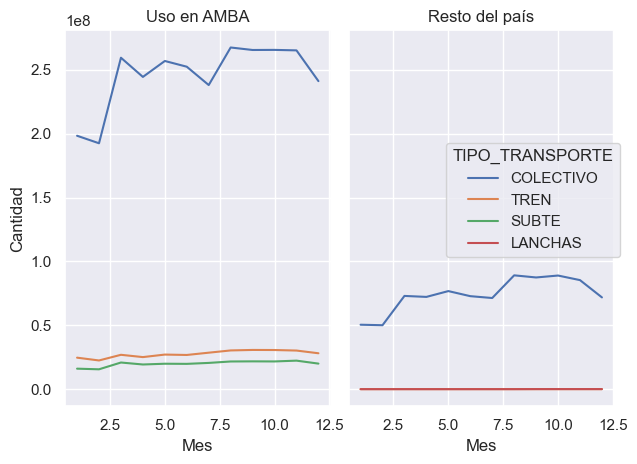

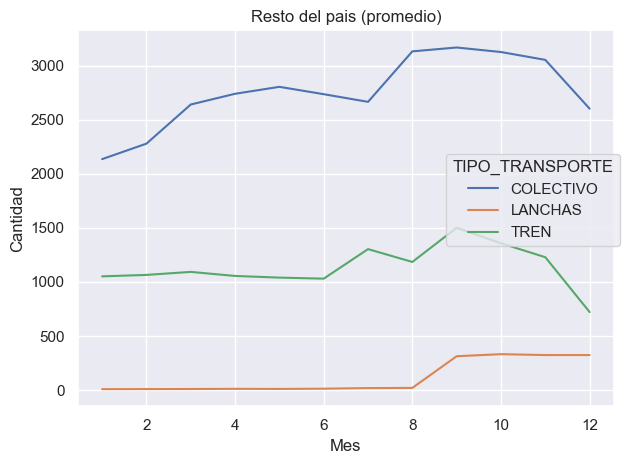

In [170]:
(
    so.Plot(data=sube,
            x="FECHA_MES",
            y="CANTIDAD",
            color="TIPO_TRANSPORTE")
    .add(so.Line(),so.Agg("sum"))
    .facet("AMBA")
    .label(x="Mes",y="Cantidad",title=lambda x: f"Uso en AMBA" if x == "SI" else f"Resto del país")
    
).show()
(
    so.Plot(data=sube[sube["AMBA"]=="NO"],
            x="FECHA_MES",
            y="CANTIDAD",
            color="TIPO_TRANSPORTE")
    .add(so.Line(),so.Agg())
    .label(x="Mes",y="Cantidad",title="Resto del pais (promedio)")
).show()


##### En ambos gráficos se observa que el colectivo es el medio de transporte más utilizado tanto en el interior del país como en el AMBA, seguido por el tren y el subte. Sin embargo, la cantidad de pasajeros que utilizan el colectivo en el AMBA supera significativamente a la del interior.

##### Además, el AMBA cuenta con un medio de transporte que el interior del país no tiene: el subte. Sumado a esto, el uso del tren es considerablemente mayor en el AMBA en comparación con el interior. Estos factores combinados explican por qué el uso de la tarjeta SUBE es mucho más elevado en el AMBA que en el interior del país

##### Es importante destacar que en el primer gráfico (Titulo: Resto del País), las líneas del tren y las lanchas están superpuestas debido a que ambas presentan valores muy bajos, casi nulos comparados al colectivo. La notacion $1e8$ representa $100.000.000$ (centenas de millones)

#### ¿Cómo difiere el uso del transporte público durante los días hábiles en comparación a los fines de semana?


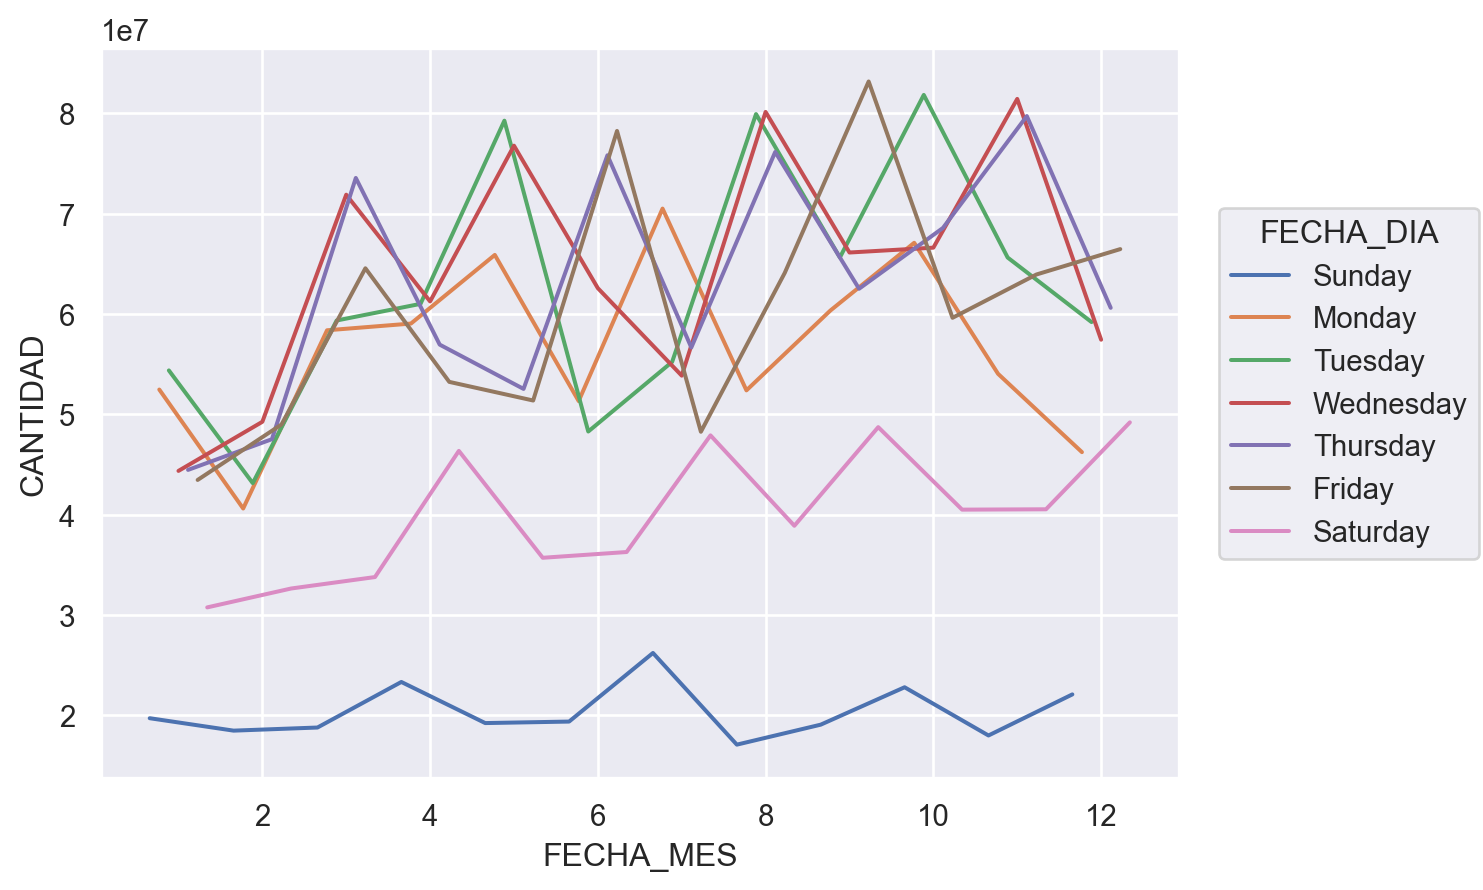

In [129]:
(
    so.Plot(data= sube,
            x= "FECHA_MES",
            y= "CANTIDAD",
            color="FECHA_DIA")
    .add(so.Line(),so.Agg("sum"),so.Dodge())
)

Podemos ver que el gráfico se puede dividir en tres zonas en términos de comprotamiento similar de los datos: `los dias hábiles`, `los sábados` y `los domingos`
- `Días hábiles` (lunes a viernes): Estos dias presentan un comportamiento similar con pcos altos y consistentes. Por ejemplo, el primer pico es prácticamente el mismo para los días miércoles y jueves,  el segundo para los díass martes y miércoles, el tercero para los días jueves y viernes, el cuarto para los días martes, miércoles y jueves el quinto para los días partes y viernes y el sexto y último pico graficado es similar para los días miércoles y  jueves

- Por otro lado, resulta interesante notar que no hay puntos de encuentro entre las líneas rosa y azul (correspondientes a los días `sábado` y `domingo` respectivamente) pero tampco hay punto de interesección entre alguna de las líneas correspondientes a los días hábiles y alguna de las líneas correspondientes a los fines de semana

Se puede concluir así, un mayor uso del transporte los días hábiles, uno considerablemente menor los días sábados y otro incluso menor los días domingos. Estos datos se corresponden con lo esperable, teniendo en cuenta que los dias hábiles son dias laborables y dias en los que funcionan las instituciones educatvias. Por otro lado, aunque en menor medida, los sabados tambien son días laborables y los domingos pasan a ser días laborales para una minoria; lo que, sumado a que la mayoria de las personas utiliza ese dia para descansar y no necesariamente utiliza el transporte público con fines sociales o de dispersión sino que elije quedarse en sus respectivos hogares, contribuye a que sea el día de la semana con menor uso del transporte público

### Cantidad de lineas en amba comparado al resto del pais

In [58]:
print(datos_amba.linea.nunique())
print(datos_amba.pasajeros.sum())

print(f"Promedio de pasajeros por linea: {datos_amba.pasajeros.sum()/datos_amba.linea.nunique()}")


419
3519514362
Promedio de pasajeros por linea: 8399795.613365155


In [59]:
print(datos_interior.linea.nunique())
print(datos_interior.pasajeros.sum())
print(f"Promedio de pasajeros por linea: {datos_interior.pasajeros.sum()/datos_interior.linea.nunique()}")

1090
890232989
Promedio de pasajeros por linea: 816727.5128440367


In [64]:
comparacion_lineas = pd.DataFrame({"Cantidad de lineas":[datos_amba.linea.nunique(),datos_interior.linea.nunique()],                                   
                                   "Cantidad de pasajeros":[datos_amba.pasajeros.sum(), datos_interior.pasajeros.sum()]})

In [67]:
comparacion_lineas.rename(index={0:"AMBA",1:"Interior"},inplace=True)

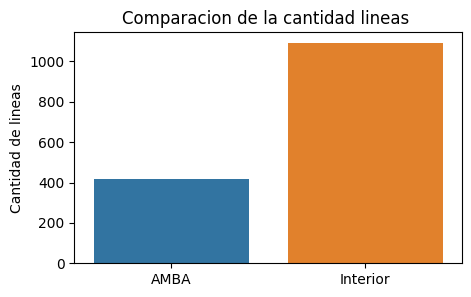

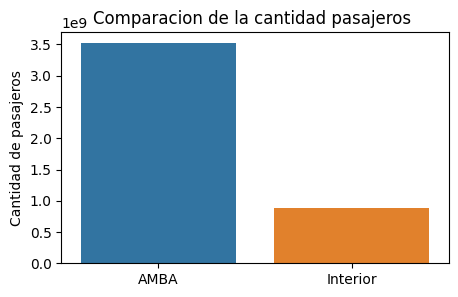

In [73]:
plt.figure(figsize=(5,3))
sns.barplot(data=comparacion_lineas, x=comparacion_lineas.index, y="Cantidad de lineas")
plt.title("Comparacion de la cantidad lineas ")
plt.show()

plt.figure(figsize=(5,3))
sns.barplot(data=comparacion_lineas, x=comparacion_lineas.index, y="Cantidad de pasajeros")
plt.title("Comparacion de la cantidad pasajeros ")
plt.show()


In [163]:
#Cantidad de lineas en AMBA
lineas_amba = sube[sube["AMBA"]=="SI"]["LINEA"].nunique()
resto_del_pais = sube[sube["AMBA"]=="NO"]
print(f"Cantidad de lineas en AMBA: {lineas_amba}\n")

# Cantidad de lineas por provincia
for provincia in resto_del_pais["PROVINCIA"].unique():
    print(f"Cantidad de lineas en {provincia}: {resto_del_pais[resto_del_pais['PROVINCIA'] == provincia]['LINEA'].nunique()}")

Cantidad de lineas en AMBA: 419

Cantidad de lineas en BUENOS AIRES: 132
Cantidad de lineas en CHUBUT: 44
Cantidad de lineas en SANTA FE: 93
Cantidad de lineas en ENTRE RÍOS: 30
Cantidad de lineas en LA PAMPA: 12
Cantidad de lineas en MENDOZA: 392
Cantidad de lineas en RÍO NEGRO: 48
Cantidad de lineas en JN: 12
Cantidad de lineas en TIERRA DEL FUEGO: 11
Cantidad de lineas en CHACO: 28
Cantidad de lineas en JUJUY: 67
Cantidad de lineas en NEUQUÉN: 60
Cantidad de lineas en FORMOSA: 12
Cantidad de lineas en CORRIENTES: 9
Cantidad de lineas en CATAMARCA: 16
Cantidad de lineas en SAN JUAN: 120
Cantidad de lineas en SAN LUIS: 14
Cantidad de lineas en CORDOBA: 31
Cantidad de lineas en SANTA CRUZ: 5
Cantidad de lineas en SANTIAGO DEL ESTERO: 6


#### En comparación con el resto de las provincias, el `AMBA` cuenta aproximadamente con 400 líneas de transporte, lo que supera considerablemente la cantidad promedio por provincia. Esta disparidad en la oferta de servicios de transporte público refleja la mayor densidad poblacional y la demanda de movilidad en el AMBA en comparación con otras regiones del país

### Empresas y lineas de transporte más concurridas

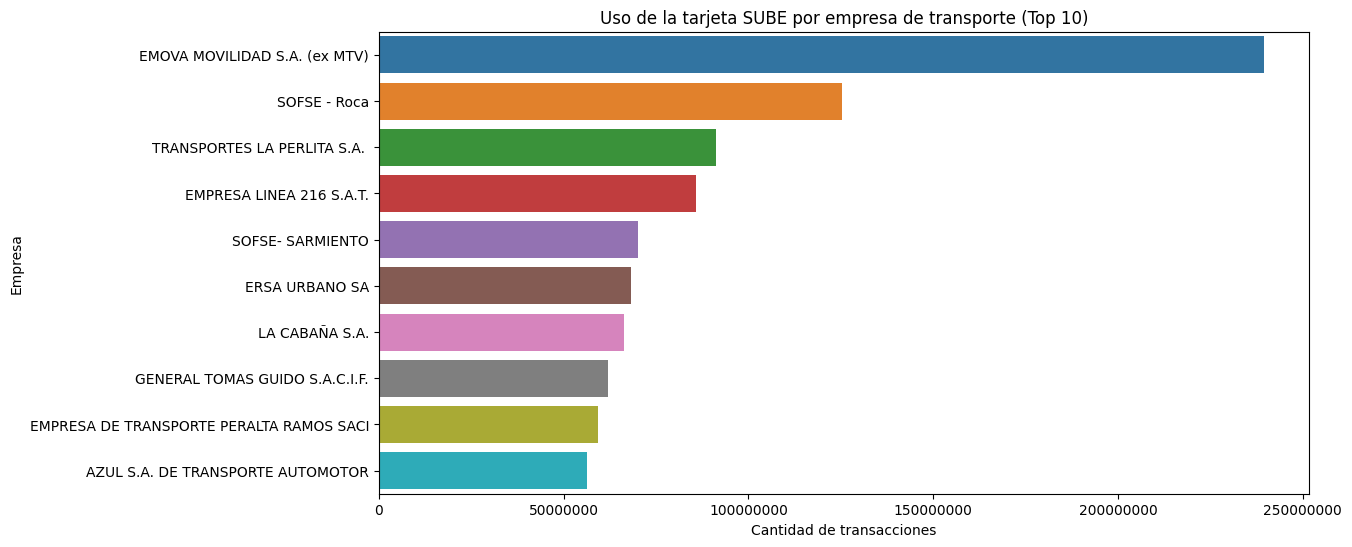

In [137]:
# Empresas de transporte con mayor uso
plt.figure(figsize=(12, 6))
empresa_usage = sube.groupby('NOMBRE_EMPRESA')['CANTIDAD'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=empresa_usage.values, y=empresa_usage.index)
plt.title('Uso de la tarjeta SUBE por empresa de transporte (Top 10)')
plt.xlabel('Cantidad de transacciones')
plt.ylabel('Empresa')
plt.ticklabel_format(style='plain', axis='x')
plt.show()


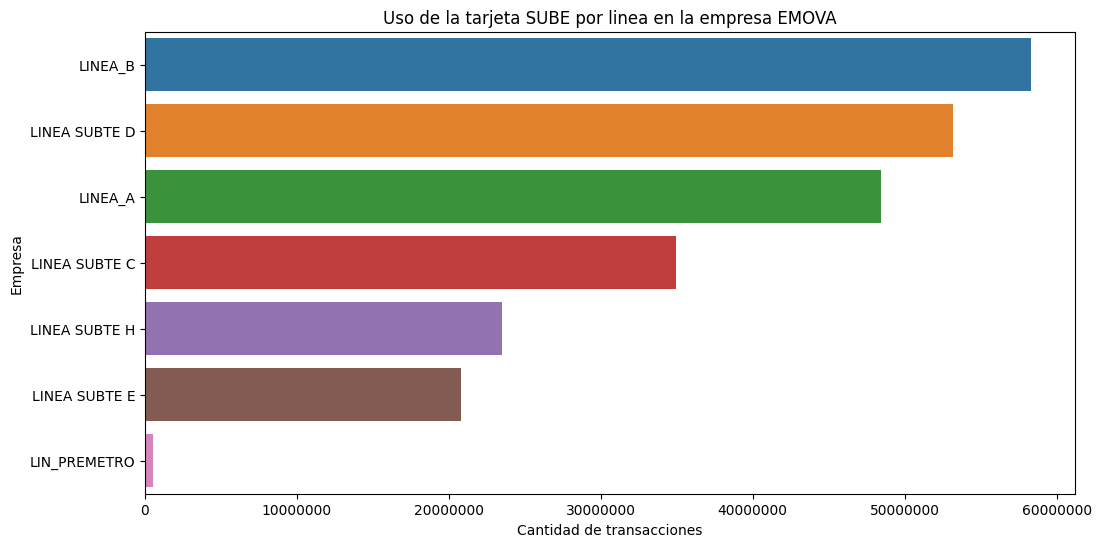

In [162]:
plt.figure(figsize=(12, 6))
emova_usage = sube[sube["NOMBRE_EMPRESA"]=="EMOVA MOVILIDAD S.A. (ex MTV)"]
emova_usage = emova_usage.groupby("LINEA")["CANTIDAD"].sum().reset_index()
emova_usage = emova_usage.sort_values(by="CANTIDAD",ascending=False)
sns.barplot(data=emova_usage,y="LINEA", x="CANTIDAD")
plt.title('Uso de la tarjeta SUBE por linea en la empresa EMOVA')
plt.xlabel('Cantidad de transacciones')
plt.ylabel('Empresa')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

#### Líneas de transporte más utilizadas

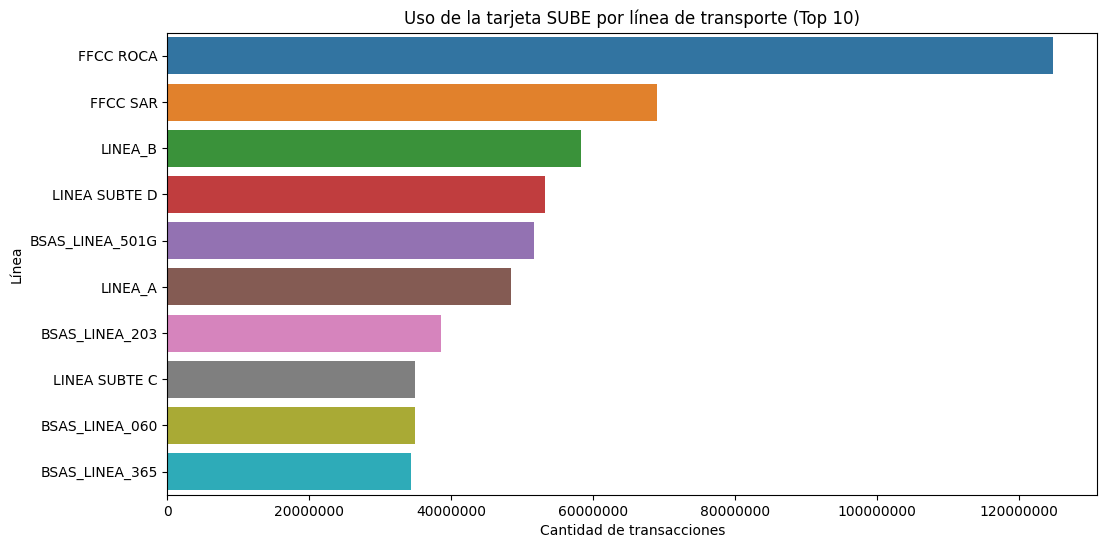

In [148]:
plt.figure(figsize=(12, 6))
linea_usage = sube.groupby('LINEA')['CANTIDAD'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=linea_usage.values, y=linea_usage.index)
plt.title('Uso de la tarjeta SUBE por línea de transporte (Top 10)')
plt.xlabel('Cantidad de transacciones')
plt.ylabel('Línea')
plt.ticklabel_format(style='plain', axis='x')
plt.show()


#### **Conclusión**:
##### En el análisis del top 10 de uso de la tarjeta SUBE por línea de transporte, podemos ver que cuatro de las líneas más utilizadas son de subte, y las dos más usadas son de tren. En cuanto a las empresas de transporte, `EMOVA MOVILIDAD S.A. (ex MTV)` y `FFCC ROCA` están en la cima de la lista, operando las líneas de subte y tren respectivamente. Ambas empresas operan en el AMBA.

##### Estos resultados muestran claramente cómo el desarrollo del tren y el subte influye en la cantidad de pasajeros en el AMBA. En el interior del país, donde no hay subtes y hay menos líneas de tren, la situación es diferente. Este análisis nos ayuda a entender la importancia de la infraestructura de transporte en el AMBA y cómo afecta la elección de medios de transporte por parte de los pasajeros

## 5. Modelado.

### **(a)** Generar un DataFrame en el que las columnas sean las líneas de colectivo (`TIPO_TRANSPORTE` == "COLECTIVO") de AMBA de jurisdicción nacional (`PROVINCIA` == "JN") y las observaciones sean los días del año. 

Es decir, cada fila del DataFrame corresponde a un día del año, y en esa fila deben figurar la cantidad de pasajeros que viajaron en cada línea de
colectivo en el día correspondiente.

Para generar el DataFrame pueden completar el siguiente código:

In [5]:
subeReg = pd.read_csv("sube-2023-regresion.csv")
datos_AMBA= subeReg[subeReg["AMBA"]=="SI"]
amba_JN= datos_AMBA[datos_AMBA["PROVINCIA"]=="JN"]
datos_ColectivoJN = amba_JN[amba_JN["TIPO_TRANSPORTE"]=="COLECTIVO"]
cols = datos_ColectivoJN.LINEA.unique() # Los nombres de laslineas de colectivo
pasajeros_por_linea = pd.DataFrame()
for col in cols:
    datos_linea = datos_ColectivoJN[datos_ColectivoJN.LINEA == col ][["DIA_TRANSPORTE", "CANTIDAD"]]
    datos_linea = datos_linea.set_index("DIA_TRANSPORTE").rename(columns={"CANTIDAD":col})
    pasajeros_por_linea=pd.concat([pasajeros_por_linea ,datos_linea ], axis = 1)

pasajeros_por_linea.head(3)

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA 5,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_119_AMBA,LINEA_164_AMBA,LINEA 119
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1681,5670,5644,5177,9109,7013,1604,2617,11235,2202,...,4832.0,4839,2449,2184,3797,5317,1882,1573.0,3210,NaN
2023-01-02,9440,21759,23284,21176,45269,29962,13921,11934,55611,13823,...,20333.0,16221,10486,12774,17374,23250,10322,7345.0,19362,NaN
2023-01-04,10540,24755,25405,23806,52873,33659,16172,13366,61721,16206,...,23041.0,18448,12193,13949,19860,26294,11981,7925.0,21784,NaN


### **(b)** Eliminar las columnas correspondientes a líneas de colectivo que tengan datos faltantes

In [6]:
# Quiero saber que columnas tienen nulos
columnas = 0
for col in pasajeros_por_linea.columns:
    if pasajeros_por_linea[col].isnull().sum() > 0:
        print(f"{col}: {pasajeros_por_linea[col].isnull().sum()}")
        columnas += 1
print(f"\nTotal de columnas con nulos: {columnas}")

BSAS_LINEA_065: 1
BSAS_LINEA_090: 1
BSAS_LINEA_114: 1
BSAS_LINEA_129: 1
BSAS_LINEA_148: 1
BSAS_LINEA_151: 1
BSAS_LINEA_194: 1
BSAS_LINEA_195: 1
LINEA 145: 1
LINEA 5: 5
LINEA_119_AMBA: 43
LINEA 119: 205

Total de columnas con nulos: 12


In [7]:
# Eliminamos esas columnas
print("Cantidad de columnas antes: ",pasajeros_por_linea.shape[1])
pasajeros_por_linea.dropna(axis=1,inplace=True)
print("Cantidad de columnas despues: ",pasajeros_por_linea.shape[1])

Cantidad de columnas antes:  136
Cantidad de columnas despues:  124


### **(c)** Se quiere ajustar la cantidad de pasajeros en la línea `BSAS_LINEA_009` en función de los pasajeros en otras líneas. 

#### Proponer tres modelos de regresión distintos. En cada modelo, pueden utilizarse la información solo de otras 5 líneas de colectivos (pueden ser distintas líneas de colectivo en los distintos modelos). Los criterios de selección de esas 5 columnas los determinan ustedes, y deben estar explicitados en el informe.

#### Primer idea de modelo: `Regresion Lineal` con 5 lineas aleatorias


In [8]:
# Seleccionamos 5 lineas aleatorias
lineas = pasajeros_por_linea.columns
# Eliminamos la linea BSAS_LINEA_009 para que no aparezca
lineas = lineas.drop("BSAS_LINEA_009")
lineas_aleatorias = np.random.choice(lineas,5)
lineas_aleatorias

array(['BSAS_LINEA_111', 'LINEA 50', 'BSAS_LINEA_063', 'BSAS_LINEA_091',
       'BSAS_LINEA_31'], dtype=object)

In [38]:
X = pasajeros_por_linea[lineas_aleatorias]
y = pasajeros_por_linea["BSAS_LINEA_009"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo = LinearRegression()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

print("Coeficientes del modelo de Regresion Lineal:\n")
for i, col in enumerate(X.columns):
    print(f"{col}: {modelo.coef_[i]}")
print(f"B_0: {modelo.intercept_}")
print(f"\nR^2: {modelo.score(X_test, y_test)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")


Coeficientes del modelo de Regresion Lineal:

BSAS_LINEA_169: 0.7903040603574671
BSAS_LINEA_061: 0.8655555474295229
BSAS_LINEA_053: 0.2510603911687237
BSAS_LINEA_179: -1.8244133070177995
BSAS_LINEA_022: 0.44652461984046116
B_0: 1414.9870845805563

R^2: 0.8560177757588792
RMSE: 3714.9926115331396


#### El segundo modelo es Ridge Regression con las 5 lineas más relacionadas con `BSAS_LINEA_009`


In [153]:
# Calcular las correlaciones de todas las líneas con `BSAS_LINEA_009`
correlaciones = pasajeros_por_linea.corr()["BSAS_LINEA_009"].drop("BSAS_LINEA_009")
lineas_correlacion = correlaciones.abs().sort_values(ascending=False).head(5).index.tolist()

print(" Líneas seleccionadas por mayor correlación: \n", lineas_correlacion)


 Líneas seleccionadas por mayor correlación: 
 ['LINEA_101', 'BSAS_LINEA_146', 'LINEA_7', 'BSAS_LINEA_024', 'LINEA_107']


In [40]:
# Hacemos esto por que sino no funciona formulaic
pasajeros_por_linea.columns = pasajeros_por_linea.columns.str.replace(" ","_")

In [229]:
# Primero separamos en entreamiento y testeo
df_train, df_test = train_test_split(pasajeros_por_linea, test_size=0.2, random_state=42)

# Contruimos las matrices X e y para entrenamiento

formula = 'BSAS_LINEA_009 ~ LINEA_101 + BSAS_LINEA_146 + LINEA_7 + BSAS_LINEA_024 + LINEA_107'
y, X =  Formula(formula).get_model_matrix(df_train)

##### Como el punto `d)` dice: 

- Si alguno de los modelos es Regresión Ridge, determinar mediante un esquema de validación el hiperparámetro α

Usamos el esquema de KFold

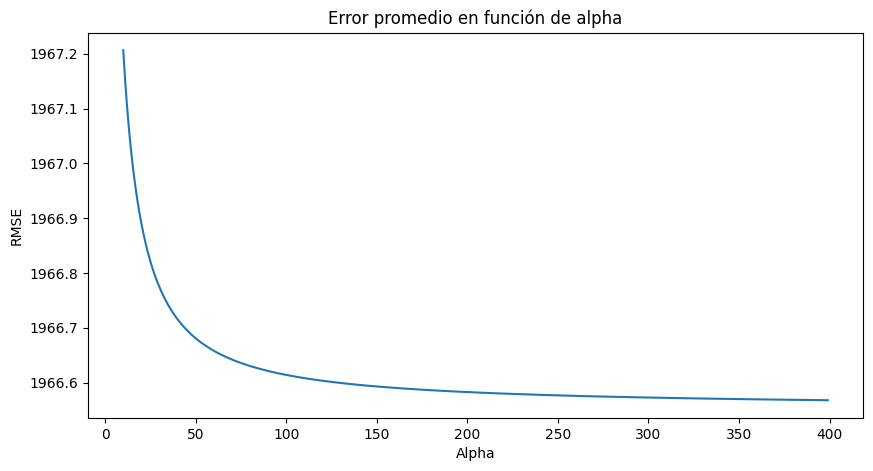

In [158]:
# Definimos un vector de parámetros a probar
alphas = np.arange(10,400,1)
# Para cada valor alpha, calculamos el error promedio al realizar validación cruzada de 5 pliegues en los datos de entrenamiento
rmses = []
cv = KFold(n_splits=5, random_state=42, shuffle=True)  # 5 pliegos
for alpha in alphas:
    # Inicializamos un modelo de Regresion Lineal sin intercept
    modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)    
    rmse = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

    ind = 0

    # Para seleccionar algunas filas dados los índices, utilizamos iloc (lo vimos en la clase 2)
    for train_index, val_index in cv.split(X):
        X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        modeloRidge.fit(X_train, y_train)

        y_pred = modeloRidge.predict(X_val)
        rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
        ind = ind + 1
        
    rmses.append(rmse.mean())

# Graficamos el error promedio en función de alpha
plt.figure(figsize=(10,5))
plt.plot(alphas, rmses)
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Error promedio en función de alpha')
plt.show()

Determinamos que el mejor valor de alpha para el modelo es entre 100 y 150 (elegimos 125)

In [160]:
alpha_optimo = 125

modeloRidge = linear_model.Ridge(alpha = alpha_optimo, fit_intercept = False)
modeloRidge.fit(X, y)

Ridge(alpha=125, fit_intercept=False)

In [161]:
formula = 'BSAS_LINEA_009 ~ LINEA_101 + BSAS_LINEA_146 + LINEA_7 + BSAS_LINEA_024 + LINEA_107'
y_test, X_test =  Formula(formula).get_model_matrix(df_test)

y_pred = modeloRidge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Para alpha = {alpha_optimo} la raíz del ECM en test es: {rmse:.5f}")

Para alpha = 125 la raíz del ECM en test es: 1986.36971


#### Tercer Modelo: Regresion lineal con la mejor combinacion entre los 35 mejores

Para este modelo, primero calculamos la suma de las combinatorias $\binom{35}{k}$ con $k$ entre 1 y 5:

$$
\sum_{i=1}^5 \binom{35}{i} = \sum_{i=1}^5 \frac{35!}{i! \cdot (35 - i)!}
$$


In [66]:
import math
combinatorias = [math.comb(35,i) for i in range(1,6)]
sum(combinatorias)

384167

Ahora, creamos una funcion para calcular el mejor de todas las posibles combinaciones y vemos cuanto tardaria 


In [28]:
def validacion_cruzada_kfold(modelo, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    rmses = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return np.mean(rmses), np.std(rmses)

In [65]:
import time
combinaciones_ejemplo = [
    ('LINEA 101',),
    ('LINEA 101', 'BSAS_LINEA_146'),
    ('LINEA 101', 'BSAS_LINEA_146', 'LINEA 7'),
    ('LINEA 101', 'BSAS_LINEA_146', 'LINEA 7', 'BSAS_LINEA_024'),
    ('LINEA 101', 'BSAS_LINEA_146', 'LINEA 7', 'BSAS_LINEA_024', 'BSAS_LINEA_108')
]

y_ejemplo = pasajeros_por_linea["BSAS_LINEA_009"]

# Evaluar cada combinación de ejemplo y medir el tiempo de ejecución
tiempos = []
for combinacion in combinaciones_ejemplo:
    X_ejemplo = pasajeros_por_linea[list(combinacion)]
    start_time = time.time()
    rmse_ejemplo, std_ejemplo = validacion_cruzada_kfold(LinearRegression(), X_ejemplo, y_ejemplo)
    end_time = time.time()
    tiempo_por_combinacion = end_time - start_time
    tiempos.append(tiempo_por_combinacion)
    #print(f"Combinación: {combinacion}, RMSE: {rmse_ejemplo:.5f}, STD: {std_ejemplo:.5f}, Tiempo: {tiempo_por_combinacion:.5f} segundos")

# Número total de combinaciones de 5 líneas entre 35
n = 35
tiempos_totales = []
for i in range(1, 6):
    contador_combinaciones = math.comb(n, i)
    tiempos_totales.append(tiempos[i-1] * contador_combinaciones)
    
print(f"\nTiempo total estimado: {sum(tiempos_totales):.2f} segundos")
print(f"Tiempo total estimado: {sum(tiempos_totales) / 60:.2f} minutos")
print(f"Tiempo total estimado: {sum(tiempos_totales) / 3600:.2f} horas")


Tiempo total estimado: 986.82 segundos
Tiempo total estimado: 16.45 minutos
Tiempo total estimado: 0.27 horas


No tarda mucho, por lo que lo probamos.

In [24]:
from itertools import combinations 
# Calcular las correlaciones de todas las líneas con `BSAS_LINEA_009`
correlaciones = pasajeros_por_linea.corr()["BSAS_LINEA_009"].drop("BSAS_LINEA_009")
lineas_correlacion = correlaciones.abs().sort_values(ascending=False).head(30).index.tolist() 

# Probar todas las combinaciones posibles de las 10 líneas
mejor_combinacion = None
combinaciones = []
cantidad_lineas = []
rmses = []
stds = []
mejor_rmse = float('inf')
mejor_std = float('inf')
for r in range(1, 6):  # Tamaños de combinaciones de 1 a 5
    for combinacion in combinations(lineas_correlacion, r):
        X = pasajeros_por_linea[list(combinacion)]
        y = pasajeros_por_linea["BSAS_LINEA_009"]
        rmse, std = validacion_cruzada_kfold(LinearRegression(), X, y)
        combinaciones.append(combinacion)
        rmses.append(rmse)
        stds.append(std)
        cantidad_lineas.append(len(combinacion))
        if rmse < mejor_rmse:
            mejor_rmse = rmse
            mejor_std = std
            mejor_combinacion = combinacion

In [25]:
data = pd.DataFrame({"Combinacion":combinaciones,"Lineas":cantidad_lineas,"RMSE":rmses,"STD":stds}).sort_values(by="RMSE")
data.head()

,Combinacion,Lineas,RMSE,STD
0,"('LINEA 101', 'BSAS_LINEA_091', 'BSAS_LINEA_10...",5,1789.912113,370.836366
1,"('LINEA 101', 'BSAS_LINEA_091', 'BSAS_LINEA_10...",5,1792.761866,352.304169
2,"('LINEA 101', 'BSAS_LINEA_091', 'BSAS_LINEA_10...",5,1800.032452,342.819407
3,"('LINEA 101', 'BSAS_LINEA_091', 'LINEA 28', 'B...",5,1801.775115,377.257550
4,"('LINEA 101', 'BSAS_LINEA_117', 'BSAS_LINEA_09...",5,1807.903732,383.420855


In [26]:
# La mejor combinacion es:
print(data.Combinacion.values[0])

('LINEA 101', 'BSAS_LINEA_091', 'BSAS_LINEA_108', 'BSAS_LINEA_111', 'BSAS_LINEA_135')


In [27]:
mejor_combinacion = ['LINEA 101', 'BSAS_LINEA_091', 'BSAS_LINEA_108', 'BSAS_LINEA_111', 'BSAS_LINEA_135']
modelo3 = LinearRegression()
X = pasajeros_por_linea[mejor_combinacion]
y = pasajeros_por_linea["BSAS_LINEA_009"]
modelo3.fit(X,y)
y_pred = modelo3.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"RMSE: {rmse:.5f}")


RMSE: 1803.57049


### **e)** Proponer un esquema de validación de los modelos y utilizarlo para seleccionar el mejor de los tres modelos propuestos.

In [22]:
def esquema_de_validacion(modelo, X, y, n_splits=5):
    cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    
    rmses = []
    for train_index, val_index in cv.split(X):
            X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            rmses.append(rmse)
        
    return rmses
        

In [41]:
# Primero separamos en entrenamiento y testeo.
df_train, df_test = train_test_split(pasajeros_por_linea, test_size=0.2, random_state=42)

# Contruimos las matrices X e y para entrenamiento para cada modelo

# Modelo 1: Regresión Lineal con las 5 líneas aleatorias
modelo1 = LinearRegression()
X_lineal = df_train[lineas_aleatorias]
y_lineal = df_train["BSAS_LINEA_009"]

# Modelo 2: Ridge Regression con las 5 líneas más correlacionadas
formula = 'BSAS_LINEA_009 ~ LINEA_101 + BSAS_LINEA_146 + LINEA_7 + BSAS_LINEA_024 + LINEA_107'
y_ridge, X_ridge =  Formula(formula).get_model_matrix(df_train)
alpha_optimo = 125
modeloRidge = linear_model.Ridge(alpha = alpha_optimo, fit_intercept = False)

# Modelo 3: Regresión Lineal con la mejor combinación de 5 líneas en el top 35
mejor_combinacion = ['LINEA_101', 'BSAS_LINEA_091', 'BSAS_LINEA_108', 'BSAS_LINEA_111', 'BSAS_LINEA_135']
modelo_top35 = LinearRegression()
X_top35 = df_train[mejor_combinacion]
y_top35 = df_train["BSAS_LINEA_009"]


In [42]:
rmses_lineal = esquema_de_validacion(modelo1, X_lineal, y_lineal, n_splits=5)
rmses_ridge = esquema_de_validacion(modeloRidge, X_ridge, y_ridge, n_splits=5)
rmses_top35 = esquema_de_validacion(modelo_top35, X_top35, y_top35, n_splits=5)

# Seleccionamos el mejor de los 3 modelos en base al error promedio
rmses_promedio = [np.mean(rmses_lineal), np.mean(rmses_ridge), np.mean(rmses_top35)]

print(f"Error promedio de Regresión Lineal: {rmses_promedio[0]:.5f}")
print(f"Error promedio de Ridge Regression: {rmses_promedio[1]:.5f}")
print(f"Error promedio de Regresión Top 35: {rmses_promedio[2]:.5f}")


Error promedio de Regresión Lineal: 3173.87196
Error promedio de Ridge Regression: 1966.60139
Error promedio de Regresión Top 35: 1855.30134


### **(f)** Para el modelo elegido, indicar la fórmula final de modelo


La fórmula de la regresión Lineal para el modelo es:
$$ y = \beta_0 + \beta_1 \cdot \text{X}_1 + \beta_2 \cdot \text{X}_2 + \beta_3 \cdot \text{X}_3 + \beta_4 \cdot \text{X}_4 + \beta_5 \cdot \text{X}_5$$
pues tenemos 5 lineas

In [43]:
X_top35.columns

Index(['LINEA_101', 'BSAS_LINEA_091', 'BSAS_LINEA_108', 'BSAS_LINEA_111',
       'BSAS_LINEA_135'],
      dtype='object')

In [45]:
modelo_top35 = LinearRegression()
modelo_top35.fit(X_top35, y_top35)
print("Coeficientes del modelo de Regresion Lineal con las 5 lineas del top 35:\n")
for i, col in enumerate(X_top35.columns):
    print(f"{col}: {modelo_top35.coef_[i]}")
print(f"B_0: {modelo_top35.intercept_}")

Coeficientes del modelo de Regresion Lineal con las 5 lineas del top 35:

LINEA_101: 0.2521469625877919
BSAS_LINEA_091: 0.23588394612406732
BSAS_LINEA_108: 0.30634169905361275
BSAS_LINEA_111: 0.21984651910665068
BSAS_LINEA_135: 0.12198203281711467
B_0: -1835.8456765569208


#### En resumen: 
$$ y = -1835.84 + 0.252 \cdot \text{Linea 101} + 0.235 \cdot \text{Bsas Linea 091} + 0.306 \cdot \text{Bsas Linea 108} + 0.219 \cdot \text{Bsas Linea 111} + 0.121 \cdot \text{Bsas Linea 135}$$